[Epoch   0] Train Loss: 0.9848 | Val Loss: 1.0351
[Epoch  10] Train Loss: 0.5445 | Val Loss: 0.8481
[Epoch  20] Train Loss: 0.3850 | Val Loss: 0.6237
[Epoch  30] Train Loss: 0.2484 | Val Loss: 0.4807
[Epoch  40] Train Loss: 0.1711 | Val Loss: 0.3920
[Epoch  50] Train Loss: 0.1437 | Val Loss: 0.3586
[Epoch  60] Train Loss: 0.1189 | Val Loss: 0.3418
[Epoch  70] Train Loss: 0.1049 | Val Loss: 0.3292
[Epoch  80] Train Loss: 0.0969 | Val Loss: 0.3092
[Epoch  90] Train Loss: 0.0911 | Val Loss: 0.3017
[Epoch  99] Train Loss: 0.0797 | Val Loss: 0.2950

Sample predictions vs true values:
Predicted: 26.50, True: 25.00
Predicted: 18.06, True: 18.60
Predicted: 20.59, True: 21.00
Predicted: 27.42, True: 23.50
Predicted: 19.08, True: 17.50
Predicted: 34.92, True: 33.80
Predicted: 20.59, True: 19.70
Predicted: 29.27, True: 24.80
Predicted: 31.99, True: 32.00
Predicted: 14.84, True: 14.00


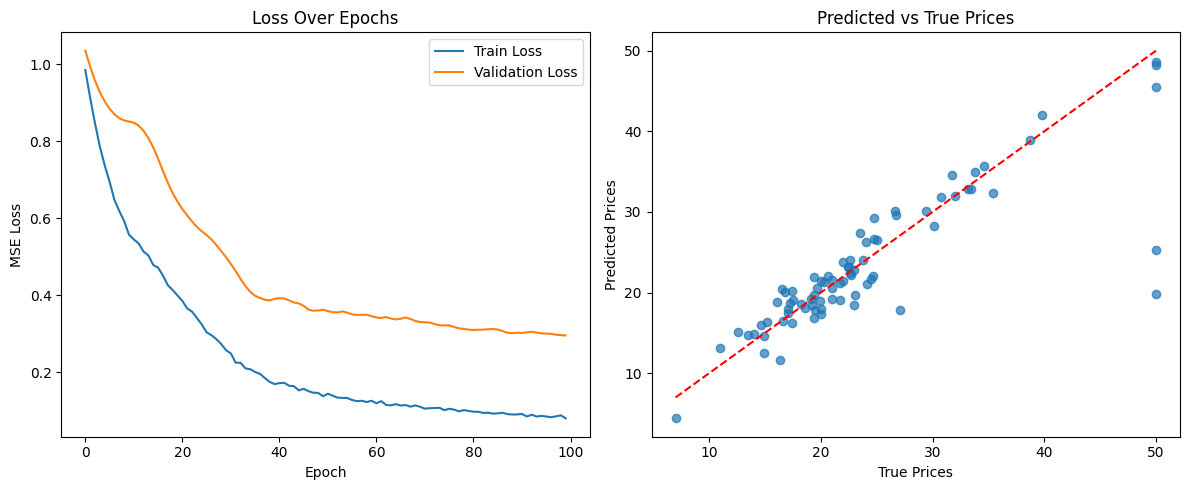

In [2]:
# File: run_boston_tab_transformer.py

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # <-- Added for plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class GatedTabTransformer(nn.Module):
    def __init__(
        self,
        categories,
        num_continuous,
        transformer_dim,
        transformer_depth,
        transformer_heads,
        transformer_dim_head,
        dim_out,
        mlp_depth,
        mlp_dimension,
        continuous_mean_std,
        gmlp_enabled=False
    ):
        super().__init__()

        self.embed_categorical = nn.ModuleList([
            nn.Embedding(cat_size, transformer_dim) for cat_size in categories
        ])

        self.norm_cont = nn.BatchNorm1d(num_continuous)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=transformer_dim,
                nhead=transformer_heads,
                dim_feedforward=transformer_dim * 2,
                batch_first=True
            ),
            num_layers=transformer_depth
        )

        input_dim = transformer_dim * len(categories) + num_continuous
        mlp_layers = []
        for _ in range(mlp_depth):
            mlp_layers.append(nn.Linear(input_dim, mlp_dimension))
            mlp_layers.append(nn.ReLU())
            input_dim = mlp_dimension
        mlp_layers.append(nn.Linear(mlp_dimension, dim_out))

        self.mlp = nn.Sequential(*mlp_layers)
        self.mean = continuous_mean_std[:, 0]
        self.std = continuous_mean_std[:, 1]

    def forward(self, x_categ, x_cont):
        embedded = [emb(x_categ[:, i]) for i, emb in enumerate(self.embed_categorical)]
        x_cat = torch.stack(embedded, dim=1)
        x_cat = self.transformer(x_cat).flatten(1)

        x_cont = (x_cont - self.mean) / self.std
        x_cont = self.norm_cont(x_cont)

        x = torch.cat([x_cat, x_cont], dim=1)
        return self.mlp(x)

df = pd.read_csv("/home/xyma/Documents/Naresh/HousingData.csv")
df = df.dropna()

X = df.drop(columns=["MEDV"]).values
y = df["MEDV"].values

categorical_cols = [3, 8]
continuous_cols = [i for i in range(X.shape[1]) if i not in categorical_cols]

X_categ = X[:, categorical_cols].astype(int)
X_cont = X[:, continuous_cols]

scaler_cont = StandardScaler()
X_cont = scaler_cont.fit_transform(X_cont)

y_mean, y_std = y.mean(), y.std()
y = (y - y_mean) / y_std

X_train_cat, X_test_cat, X_train_cont, X_test_cont, y_train, y_test = train_test_split(
    X_categ, X_cont, y, test_size=0.2, random_state=42
)

category_sizes = [int(X[:, col].max()) + 1 for col in categorical_cols]

mean = X_train_cont.mean(axis=0)
std = X_train_cont.std(axis=0)
cont_mean_std = torch.tensor(np.stack([mean, std], axis=1), dtype=torch.float32)

X_train_cat = torch.tensor(X_train_cat, dtype=torch.long)
X_train_cont = torch.tensor(X_train_cont, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_cat = torch.tensor(X_test_cat, dtype=torch.long)
X_test_cont = torch.tensor(X_test_cont, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

model = GatedTabTransformer(
    categories=category_sizes,
    num_continuous=len(continuous_cols),
    transformer_dim=32,
    transformer_depth=2,
    transformer_heads=4,
    transformer_dim_head=16,
    dim_out=1,
    mlp_depth=2,
    mlp_dimension=64,
    continuous_mean_std=cont_mean_std,
    gmlp_enabled=False
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_cat, X_train_cont)
    train_loss = criterion(preds, y_train)
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_cat, X_test_cont)
        val_loss = criterion(val_preds, y_test)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"[Epoch {epoch:3d}] Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

model.eval()
with torch.no_grad():
    val_preds = model(X_test_cat, X_test_cont)

    val_preds_original = val_preds.squeeze().cpu().numpy() * y_std + y_mean
    y_test_original = y_test.squeeze().cpu().numpy() * y_std + y_mean

    print("\nSample predictions vs true values:")
    for pred, true in zip(val_preds_original[:10], y_test_original[:10]):
        print(f"Predicted: {pred:.2f}, True: {true:.2f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_original, val_preds_original, alpha=0.7)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         color='red', linestyle='--')
plt.title("Predicted vs True Prices")
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")

plt.tight_layout()
plt.show()







# Import libraries for data handling, modeling, training, and plotting
# Define transformer-based model for tabular regression
# - Embeds categorical data
# - Normalizes and combines with continuous features
# - Uses Transformer + MLP to predict target
# Load housing data, drop missing rows
# Split into categorical and continuous features
# Normalize continuous inputs and target (y)
# Split into training/testing sets
# Convert data to PyTorch tensors
# Prepare category sizes and normalization stats
# Instantiate model with embedding, transformer, and MLP settings
# Set MSE loss and Adam optimizer
# Prepare to track loss over epochs
# Train for fixed epochs
# Forward pass, compute loss, backpropagate, update weights
# Evaluate on test set and log losses
# Predict on test set, denormalize results
# Print first 10 predicted vs actual values
# Plot training/validation loss and predicted vs true prices
